# Stance Classification by fine-tuning BERT-based models using [PyTorch Lightning](https://www.pytorchlightning.ai)

In [162]:
TrainData_name = 'data/Mawqif_AllTargets_Train.csv'
TestData_name = 'data/Mawqif_AllTargets_Blind Test.csv'

#selectedTarget = 'Covid Vaccine'
#selectedTarget = 'Digital Transformation'
selectedTarget = 'Women empowerment'

#Ex_name = 'MARBERT_'+selectedTarget+'_Stance'
#Ex_name = 'AraBERT_'+selectedTarget+'_Stance'
#Ex_name = 'camelbert-da_'+selectedTarget+'_Stance'
Ex_name = 'AraBERT-twitter_Stance_V2'

#"UBC-NLP/MARBERT
#"aubmindlab/bert-base-arabertv02"
#"CAMeL-Lab/bert-base-arabic-camelbert-da"
selectedModel = "aubmindlab/bert-base-arabertv02-twitter"

N_EPOCHS = 1
BATCH_SIZE = 16


# Environment Settings

In [163]:
# Import Basics
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import pickle
import re
import os

In [164]:
os.cpu_count()

8

In [165]:
# Pytorch 
import torch
import torchmetrics
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
#from pytorch_lightning.metrics.functional import accuracy, f1, auroc
#https://torchmetrics.readthedocs.io/en/stable/metrics.html
#https://stackoverflow.com/questions/69139618/torchmetrics-does-not-work-with-pytorchlightning
from torchmetrics.functional import accuracy, f1_score, roc, precision, recall, confusion_matrix
from torchmetrics.utilities.compute import auc
from sklearn.metrics import classification_report, multilabel_confusion_matrix

In [166]:
# Visualisation
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10
tqdm.pandas()

In [167]:
pl.seed_everything(42)

Seed set to 42


42

# Load the Data

In [168]:
df = pd.read_csv(TrainData_name)
df.head(100)

,ID,text,target,stance,stance:confidence,against_reason,favor_reason,none_reason,sarcasm,sarcasm:confidence,sentiment,sentiment:confidence,datetime,Date
0,1,عشان يلمع صورته ويعنني تمكين المرأة ويصير ترن...,Women empowerment,Against,0.5116,A_Explicit,NaN,NaN,No,1.0000,Negative,1.0000,2021-01-16 03:19:19+00:00,16/01/2021
1,3,روح حلل محد يم تطعيم كورونا شف الحرم البارح م...,Covid Vaccine,NaN,0.4003,NaN,NaN,Not clear,Yes,0.5990,Neutral,0.6180,2022-04-28 11:12:56+00:00,28/04/2022
2,4,هذا ما يُعرّف بـ'فوبيا المرأة المُتمكنة' آفة ف...,Women empowerment,Favor,0.8171,NaN,F_Explicit,NaN,Yes,0.8145,Negative,0.8251,2022-04-02 07:45:42+00:00,02/04/2022
3,6,#LEAP22 مؤتمر يجمع اشهر وابرز المؤثرين في الم...,Digital Transformation,Favor,1.0000,NaN,F_Explicit,NaN,No,1.0000,Positive,0.7531,2022-02-02 18:24:09+00:00,02/02/2022
4,7,خصوصية البيانات وحمايتها في المنظمة مطلب ولكن ...,Digital Transformation,Favor,0.7559,NaN,F_Explicit,NaN,No,1.0000,Neutral,0.8116,2022-03-27 10:36:04+00:00,27/03/2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,114,الحمد لله هذا بالفعل هو عصر السرعة ويجب على ج...,Digital Transformation,Favor,1.0000,NaN,F_Explicit,NaN,No,1.0000,Positive,0.9087,2020-12-13 12:56:31+00:00,13/12/2020
96,115,ذكرتني بواحد يسولف يثني على القرارت الخاصة ب...,Women empowerment,Against,0.7396,A_Explicit,NaN,NaN,No,1.0000,Negative,0.6096,2022-04-18 13:48:34+00:00,18/04/2022
97,117,مع مرور الوقت تبين أن تطعيم كورونا فاشل فاشل ...,Covid Vaccine,Against,1.0000,A_Explicit,NaN,NaN,No,1.0000,Negative,0.7852,2021-09-07 11:18:47+00:00,07/09/2021
98,118,MENTION لن يقضي التطعيم على كورونا لأنه تطعيم...,Covid Vaccine,Against,1.0000,A_Explicit,NaN,NaN,No,1.0000,Negative,1.0000,2021-09-18 23:09:09+00:00,18/09/2021


In [169]:
print(df['target'].unique())
print()
print(df['stance'].unique())
print()
print(df['sarcasm'].unique())
print()
print(df['sentiment'].unique())

['Women empowerment' 'Covid Vaccine' 'Digital Transformation']

['Against' nan 'Favor']

['No' 'Yes']

['Negative' 'Neutral' 'Positive']


In [170]:
# split the data into training 70% and validation 15% and test 15%

stance_mapping = {np.nan: 0, 'Favor': 1, 'Against': 2}
sarcasm_mapping = {'No': 0, 'Yes': 1}
sentiment_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}

df['stance'] = df['stance'].map(stance_mapping)
df['sarcasm'] = df['sarcasm'].map(sarcasm_mapping)
df['sentiment'] = df['sentiment'].map(sentiment_mapping)

train_df, val_df = train_test_split(df, test_size=0.30, stratify=df['stance'], random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.50, stratify=val_df['stance'], random_state=42)



In [171]:

print(df.shape, train_df.shape, val_df.shape, test_df.shape)

(3502, 14) (2451, 14) (525, 14) (526, 14)


In [172]:
#Include only rows from specefic target
print(train_df.shape, val_df.shape, test_df.shape)

(2451, 14) (525, 14) (526, 14)


In [173]:
# Prepare dataframe
train_df = train_df[['ID','text','stance','target', 'sarcasm', 'sentiment']]
val_df = val_df[['ID','text','stance','target', 'sarcasm', 'sentiment']]
test_df = test_df[['ID','text','stance','target', 'sarcasm', 'sentiment']]

train_df.head(100)

,ID,text,stance,target,sarcasm,sentiment
2554,2997,الدولة لم تُجبر احد على اخذ اللقاح إطلاقا ول...,1,Covid Vaccine,0,1
660,786,تمكين المراه بانها تصير خدامه لمديرها وللناس ...,2,Women empowerment,0,0
1765,2076,الحمد لله على كل شي تم تطعيم الجرعة الثانية ...,1,Covid Vaccine,0,2
527,629,#البحث_العلمي #إلى_كل_باحث_و_باحثةسوف مع ال...,1,Digital Transformation,0,1
1822,2144,#مسابقة_ابوناصر١٤ (2030) رؤية المستقبل...,1,Digital Transformation,0,1
...,...,...,...,...,...,...
566,675,عبدالغفار يكشف أسباب انخفاض إصابات كورونا ويؤك...,1,Covid Vaccine,0,1
2127,2500,عاجبني دخول المرأة في كل هالمجالات بكل سلاسة و...,1,Women empowerment,0,2
2397,2811,الحمد لله ثم الشكر لولاة أمرنا حفظهم الله الذي...,1,Women empowerment,0,2
2092,2456,من خلال كرورنا اتضح لنا ان التحول الالكتروني ...,1,Digital Transformation,0,2


# Data Analysis (training set)

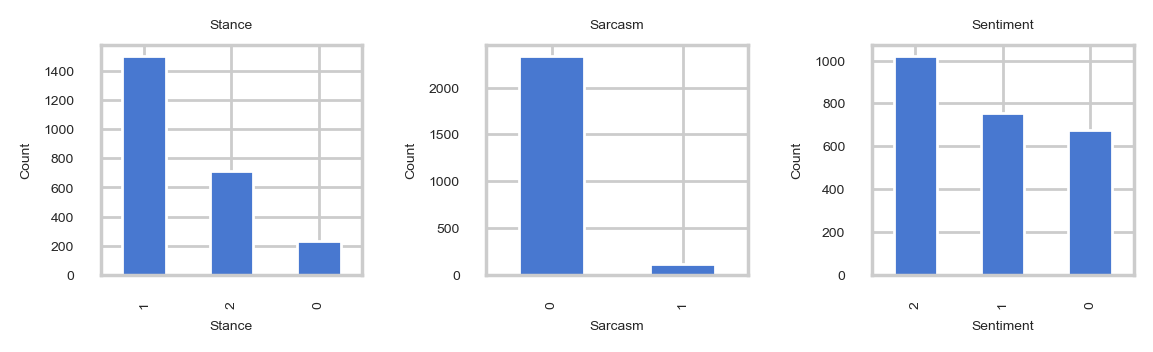

In [174]:
# Set the figure size and create subplots
fig, axs = plt.subplots(1, 3, figsize=(6, 2))  # Adjust the width and height as needed

# Plot the first subplot for 'stance'
train_df['stance'].value_counts().sort_values(ascending=False).plot(kind="bar", ax=axs[0])
axs[0].set_title("Stance", fontsize=5)
axs[0].set_xlabel("Stance", fontsize=5)
axs[0].set_ylabel("Count", fontsize=5)
axs[0].tick_params(axis='both', which='major', labelsize=5)

# Plot the second subplot for 'sarcasm'
train_df['sarcasm'].value_counts().sort_values(ascending=False).plot(kind="bar", ax=axs[1])
axs[1].set_title("Sarcasm", fontsize=5)
axs[1].set_xlabel("Sarcasm", fontsize=5)
axs[1].set_ylabel("Count", fontsize=5)
axs[1].tick_params(axis='both', which='major', labelsize=5)

# Plot the third subplot for 'sentiments'
train_df['sentiment'].value_counts().sort_values(ascending=False).plot(kind="bar", ax=axs[2])
axs[2].set_title("Sentiment", fontsize=5)
axs[2].set_xlabel("Sentiment", fontsize=5)
axs[2].set_ylabel("Count", fontsize=5)
axs[2].tick_params(axis='both', which='major', labelsize=5)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Data Preprocessing

In [175]:
model_name = "bert-base-arabertv02"

In [176]:
from arabert.preprocess import ArabertPreprocessor

#https://github.com/aub-mind/arabert/blob/master/preprocess.py
# Default values of parameters:
#ArabertPreprocessor(model_name: str, remove_html_markup: bool=True, replace_urls_emails_mentions: bool=True, strip_tashkeel: bool=True, 
#                    strip_tatweel: bool=True, insert_white_spaces: bool=True, remove_non_digit_repetition: bool=True, keep_emojis: bool=None,
#                    replace_slash_with_dash: bool=None, map_hindi_numbers_to_arabic: bool=None, apply_farasa_segmentation: bool=None)

arabert_prep = ArabertPreprocessor(model_name=model_name)

In [177]:
sample_tweet = train_df.iloc[0]
sample_tweet

ID                                                        2997
text           الدولة لم تُجبر احد على اخذ اللقاح إطلاقا ول...
stance                                                       1
target                                           Covid Vaccine
sarcasm                                                      0
sentiment                                                    1
Name: 2554, dtype: object

In [178]:
sample_tweet.text

'  الدولة لم تُجبر احد على اخذ اللقاح إطلاقا ولم يصدر اي قانون في هيئة إجبار ..الدولة قامت بحماية مواطنيها حسب التوجه المناسب لها وأصدرت توجيهات بعدم دخول أي منشأة إلا بشهادة تطعيم وهذا حقها من يرفض التحصين لايتجه لهذي المنشآت فقط لا'

In [179]:
sample_text = arabert_prep.preprocess(sample_tweet.text)
sample_text

'الدولة لم تجبر احد على اخذ اللقاح إطلاقا ولم يصدر اي قانون في هيئة إجبار . . الدولة قامت بحماية مواطنيها حسب التوجه المناسب لها وأصدرت توجيهات بعدم دخول أي منشأة إلا بشهادة تطعيم وهذا حقها من يرفض التحصين لايتجه لهذي المنشآت فقط لا'

# Encoding

In [180]:
tokenizer = AutoTokenizer.from_pretrained(selectedModel)

In [181]:
model = AutoModel.from_pretrained(selectedModel)

Some weights of BertModel were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02-twitter and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [182]:
encoding = tokenizer.encode_plus(
  sample_text,
  add_special_tokens=True,
  max_length=128, # Tokens in each sequence
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

In [183]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [184]:
encoding['input_ids'].shape , encoding['attention_mask'].shape

(torch.Size([1, 128]), torch.Size([1, 128]))

In [185]:
encoding['input_ids'].squeeze()[:20]

tensor([    2,   975,   407, 34907,  1680,   323,  9742, 28892, 21531,  1174,
         6640,   897,  1575,   305,  1860, 23865,    20,    20,   975,  2447])

In [186]:
encoding['attention_mask'].squeeze()[:20]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [187]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'].squeeze()[:20]))

['[CLS]', 'الدولة', 'لم', 'تجبر', 'احد', 'على', 'اخذ', 'اللقاح', 'إطلاقا', 'ولم', 'يصدر', 'اي', 'قانون', 'في', 'هيئة', 'إجبار', '.', '.', 'الدولة', 'قامت']


In [188]:
output = model(encoding["input_ids"], encoding["attention_mask"])

In [189]:
output.last_hidden_state.shape, output.pooler_output.shape

(torch.Size([1, 128, 768]), torch.Size([1, 768]))

# Prepare dataset

In [190]:
token_counts = []

for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(row.text, max_length=512, truncation=True))
  token_counts.append(token_count)

F:\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


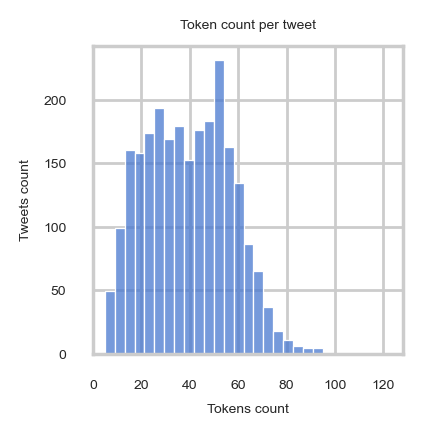

In [191]:
plt.figure(figsize=(2, 2))
sns.histplot(token_counts)
plt.xlim([0, 128])
plt.title("Token count per tweet", fontsize=5)
plt.xlabel("Tokens count", fontsize=5)
plt.ylabel("Tweets count", fontsize=5)
plt.tick_params(axis='both', which='major', labelsize=5)


In [192]:
MAX_TOKEN_COUNT = 128 #Selection is based on the previous graph 

In [193]:
class TweetStanceDataset(Dataset):
    def __init__(
        self, 
        data: pd.DataFrame, 
        tokenizer: AutoTokenizer,
        text_preprocessor=None,
        max_token_len: int = 128  # Assuming 128 as a default maximum token length
    ):
        self.data = data
        self.tokenizer = tokenizer
        self.text_preprocessor = text_preprocessor
        self.max_token_len = max_token_len
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]
    
        text = data_row.text
        if self.text_preprocessor is not None:
            text = self.text_preprocessor.preprocess(text)
    
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_token_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
    
        # Prepare the labels as tensors
        stance_label = torch.tensor(data_row.stance, dtype=torch.long)  # Assuming 'stance' column is categorical data
        sentiment_label = torch.tensor(data_row.sentiment, dtype=torch.long)  # Assuming 'sentiment' is also categorical
        sarcasm_label = torch.tensor(data_row.sarcasm, dtype=torch.long)  # Assuming 'sarcasm' is categorical
    
        return dict(
            text=text,
            input_ids=encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            stance_labels=stance_label,
            sentiment_labels=sentiment_label,
            sarcasm_labels=sarcasm_label
        )


In [194]:
train_dataset = TweetStanceDataset(train_df, tokenizer, max_token_len=MAX_TOKEN_COUNT)

## to be sure every thing is going right:
print (len(train_dataset) == len(train_df))

True


In [195]:
sample_item = train_dataset[50]

In [196]:
sample_item.keys()

dict_keys(['text', 'input_ids', 'attention_mask', 'stance_labels', 'sentiment_labels', 'sarcasm_labels'])

In [197]:
print(sample_item['input_ids'].shape)
print(sample_item['attention_mask'].shape)

torch.Size([128])
torch.Size([128])


In [198]:
print(sample_item["text"])
print(sample_item["stance_labels"])
print(sample_item["sentiment_labels"])
print(sample_item["sarcasm_labels"])

 اشوف ان تمكين الشباب اولى. المرأة اساساً مجالات عملها محصوره بحكم طبيعتها: معلمه  ممرضه،دكتوره بقسم النساء . وليس مطلوب منها لا بناء بيت ولا نفقه على زوج ولاشي.
tensor(1)
tensor(1)
tensor(0)


# Training Setup

In [199]:
class TweetDataModule(pl.LightningDataModule):
    def __init__(
        self, 
        train_df, 
        val_df,
        test_df,
        tokenizer, 
        text_preprocessor=None,
        batch_size=8,  # This default value
        token_len=128  # This default value
    ):
        super().__init__()
        self.batch_size = batch_size
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.text_preprocessor = text_preprocessor
        self.token_len = token_len

    def setup(self, stage=None):
        self.train_dataset = TweetStanceDataset(
            self.train_df, 
            self.tokenizer,
            self.text_preprocessor,
            self.token_len
        )
        self.val_dataset = TweetStanceDataset(
            self.val_df, 
            self.tokenizer,
            self.text_preprocessor,
            self.token_len
        )
        self.test_dataset = TweetStanceDataset(
            self.test_df,
            self.tokenizer,
            self.text_preprocessor,
            self.token_len
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0  # Adjust based on your system capabilities
        )

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=0)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=0)


In [200]:
data_module = TweetDataModule(train_df, val_df, test_df, tokenizer, batch_size=BATCH_SIZE, token_len=MAX_TOKEN_COUNT)
data_module.setup()

In [201]:
# to be sure every thing is going right:
for batch in data_module.train_dataloader():
    print(len(batch))
    print(batch["input_ids"].shape, batch["attention_mask"].shape) #first dim should be batch size, and second dim should be maximum token len
    # 'stance_labels', 'sentiment_labels', 'sarcasm_labels' #dim should be maximum token len
    print(batch["stance_labels"].shape) 
    print(batch["sentiment_labels"].shape)
    print(batch["sarcasm_labels"].shape)
    print("_____________________________________________________________________________________________________________")
    print(batch)
    break

6
torch.Size([16, 128]) torch.Size([16, 128])
torch.Size([16])
torch.Size([16])
torch.Size([16])
_____________________________________________________________________________________________________________
{'text': ['كما ان التحول التقني للصحافة لن يشفع لها دون مواكبة لقضايا المواطن والجمهور عموما.. صحافة العلاقات العامه لم يعد لها مكان اليوم. تطابق المضامين الصحفية افقد الجمهور الثقة في صحافته', 'MENTION MENTION MENTION ي رجال انت تدري وش يصير ع المدى البعيد سواء اخذت وإلا ماخذت  الاقدار بيد الله واللقاحات  معروفة منذ القدم روح شوف دقتر تطعيمات  الاطفال تحصل تطعيمات جديدة مالها حتى سنتين جات ع تطعيم كورونا', 'في عالم يتقدم بسرعة نحو التحول الرقمي بالكامل   تعد رسائل البريد الإلكتروني جزءًا لا يمكن الاستغناء عنه في حياتنا العملية. يتم إرسال جميع رسائلنا الأساسية وإيجازات المهام والبيانات الرسمية والإعلانات وما إلى ذلك عبر البريد الإلكتروني.  #Android #Gmail  URL URL', 'الشرايح اللي في تطعيم كورونا اشتغلت يا رجالة URL', '"لا تتسرعوا في تطعيم الأطفال ما دامت الصورة الكاملة غير واضحة. مر

# Modelling

In [202]:
class SingleTargetPredictor(pl.LightningModule):
    def __init__(self, n_classes, steps_per_epoch=None, n_epochs=None, labels_name='stance_labels'):
        super().__init__()
        
        self.bert = AutoModel.from_pretrained(selectedModel, return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        
        self.steps_per_epoch = steps_per_epoch
        self.n_epochs = n_epochs
        self.criterion = nn.CrossEntropyLoss()
        self.labels_name = labels_name

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids, attention_mask=attention_mask).pooler_output
        output = self.classifier(output)
        output = torch.softmax(output, dim=1)
        loss = self.criterion(output, batch[self.labels_name])
        return loss, output
    
    def process_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        outputs = self(input_ids, attention_mask)
        labels = batch[self.labels_name]
        loss = self.criterion(outputs, labels)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self.process_step(batch, batch_idx)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        loss = self.process_step(batch, batch_idx)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return {"test_loss": loss}
    
    def validation_step(self, batch, batch_idx):
        loss = self.process_step(batch, batch_idx)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return {"val_loss": loss}


    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=2e-5)
        warmup_steps = self.steps_per_epoch // 3
        total_steps = self.steps_per_epoch * self.n_epochs - warmup_steps
        scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)
        return [optimizer], [scheduler]


In [203]:
class TweetPredictor(pl.LightningModule):
    def __init__(self, 
                 n_classes=3, 
                 steps_per_epoch=None, 
                 n_epochs=None, 
                 labels_name='stance_labels',
                 stance_model=None,
                 sentiment_model=None,
                 sarcasm_model=None):
        super().__init__()
        
        self.stance_bert = stance_model
        self.sentiment_bert = sentiment_model
        self.sarcasm_bert = sarcasm_model
        
        for param in self.stance_bert.parameters():
            param.requires_grad = False
        for param in self.sentiment_bert.parameters():
            param.requires_grad = False
        for param in self.sarcasm_bert.parameters():
            param.requires_grad = False
        
        self.classifier = nn.Linear( 3 + 3 + 2, n_classes)
        
        self.steps_per_epoch = steps_per_epoch
        self.n_epochs = n_epochs
        self.criterion = nn.CrossEntropyLoss()
        self.labels_name = labels_name

    def forward(self, input_ids, attention_mask):
        
        bert_stance_output = self.stance_bert(input_ids, attention_mask=attention_mask).pooler_output
        bert_sentiment_output = self.sentiment_bert(input_ids, attention_mask=attention_mask).pooler_output
        bert_sarcasm_output = self.sarcasm_bert(input_ids, attention_mask=attention_mask).pooler_output

        classifier_input = torch.cat((bert_stance_output, bert_sentiment_output, bert_sarcasm_output), dim=1)
        classifier_output = self.classifier(classifier_input)
        output = torch.softmax(classifier_output, dim=1)
        
        loss = self.criterion(output, batch[self.labels_name])
        
        return loss, output
    
    def process_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        outputs = self(input_ids, attention_mask)
        labels = batch[self.labels_name]
        loss = self.criterion(outputs, labels)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self.process_step(batch, batch_idx)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        loss = self.process_step(batch, batch_idx)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return {"test_loss": loss}
    
    def validation_step(self, batch, batch_idx):
        loss = self.process_step(batch, batch_idx)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return {"val_loss": loss}


    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=2e-5)
        warmup_steps = self.steps_per_epoch // 3
        total_steps = self.steps_per_epoch * self.n_epochs - warmup_steps
        scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)
        return [optimizer], [scheduler]


In [204]:
stance_model = SingleTargetPredictor(n_classes=3, steps_per_epoch=len(train_df) // BATCH_SIZE, n_epochs=N_EPOCHS, labels_name='stance_labels')
sentiment_model = SingleTargetPredictor(n_classes=3, steps_per_epoch=len(train_df) // BATCH_SIZE, n_epochs=N_EPOCHS, labels_name='sentiment_labels')
sarcasm_model = SingleTargetPredictor(n_classes=2, steps_per_epoch=len(train_df) // BATCH_SIZE, n_epochs=N_EPOCHS, labels_name='sarcasm_labels')

Some weights of BertModel were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02-twitter and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertModel were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02-twitter and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertModel were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02-twitter and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [205]:
checkpoint_callback = ModelCheckpoint(dirpath="checkpoints", filename="best-checkpoint", save_top_k=1,
    verbose=True, monitor="val_loss", mode="min")

logger = TensorBoardLogger("lightning_logs", name="tweet-stance")

In [206]:
# Define the pytorch lighting trainer:
stance_trainer = pl.Trainer(logger=logger, enable_checkpointing=checkpoint_callback, accelerator="auto",
  devices=1, max_epochs=N_EPOCHS, enable_progress_bar=True
)
sentiment_trainer = pl.Trainer(logger=logger, enable_checkpointing=checkpoint_callback, accelerator="auto",
  devices=1, max_epochs=N_EPOCHS, enable_progress_bar=True
)
sarcasm_trainer = pl.Trainer(logger=logger, enable_checkpointing=checkpoint_callback, accelerator="auto",
  devices=1, max_epochs=N_EPOCHS, enable_progress_bar=True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


# Training Berts

In [213]:
print("Model device:", next(model.parameters()).device)
print("Input device:", data_module.device)


Model device: cpu


AttributeError: 'TweetDataModule' object has no attribute 'device'

In [207]:
stance_trainer.fit(stance_model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
F:\anaconda3\lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name       | Type             | Params
------------------------------------------------
0 | bert       | BertModel        | 135 M 
1 | classifier | Linear           | 2.3 K 
2 | criterion  | CrossEntropyLoss | 0     
------------------------------------------------
135 M     Trainable params
0         Non-trainable params
135 M     Total params
540.783   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

F:\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument target in method wrapper_CUDA_nll_loss_forward)

In [ ]:
stance_trainer.test(datamodule=data_module)

In [ ]:
sentiment_trainer.fit(sentiment_model, data_module)

In [ ]:
sentiment_trainer.test(datamodule=data_module)

In [ ]:
sarcasm_trainer.fit(sarcasm_model, data_module)

In [ ]:
sarcasm_trainer.test(datamodule=data_module)

In [ ]:
stance_model_path = "F:\\mx-projects\\NLP\\lightning_logs\\temp\\stance.ckpt"
sentiment_model_path = "F:\\mx-projects\\NLP\\lightning_logs\\temp\\sentiment.ckpt"
sarcasm_model_path = "F:\\mx-projects\\NLP\\lightning_logs\\temp\\sarcasm.ckpt"

print(os.path.exists(stance_model_path))
print(os.path.exists(sentiment_model_path))
print(os.path.exists(sarcasm_model_path))

In [ ]:

stance_trained_model = SingleTargetPredictor.load_from_checkpoint(stance_model_path, n_classes=3, steps_per_epoch=len(train_df) // BATCH_SIZE, n_epochs=N_EPOCHS, labels_name='stance_labels')

sentiment_trained_model = SingleTargetPredictor.load_from_checkpoint(sentiment_model_path, n_classes=3, steps_per_epoch=len(train_df) // BATCH_SIZE, n_epochs=N_EPOCHS, labels_name='sentiment_labels')

sarcasm_trained_model = SingleTargetPredictor.load_from_checkpoint(sarcasm_model_path, n_classes=2, steps_per_epoch=len(train_df) // BATCH_SIZE, n_epochs=N_EPOCHS, labels_name='sarcasm_labels')


In [ ]:
ensembel_model = TweetPredictor(n_classes=3, steps_per_epoch=len(train_df) // BATCH_SIZE, n_epochs=N_EPOCHS, labels_name='stance_labels', stance_model=stance_model_path, sentiment_model=sentiment_model_path, sarcasm_model=sarcasm_model_path
)

ensembel_trainer = pl.Trainer(logger=logger, enable_checkpointing=checkpoint_callback, accelerator="auto",
  devices=1, max_epochs=N_EPOCHS, enable_progress_bar=True
)

In [ ]:
ensembel_trainer.fit(ensembel_model, data_module)

In [ ]:
ensembel_trainer.test(datamodule=data_module)

# Training Combiner

# Predection

In [ ]:
trained_model = TweetPredictor.load_from_checkpoint("F:/mx-projects/NLP/lightning_logs/tweet-stance/version_4/checkpoints/epoch=5-step=924.ckpt", n_stance_classes=3, n_sentiment_classes=3, n_sarcasm_classes=2)
trained_model.freeze()
trained_model = trained_model.to("cpu")

We put our model into "eval" mode, and we're ready to make some predictions. Here's the prediction on a sample:

In [ ]:
def predict(text, model, tokenizer):
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,  # Ensure this aligns with the model's expected input size
        return_token_type_ids=False,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    # Prediction
    with torch.no_grad():  # Turn off gradients for prediction
        model.eval()  # Set the model to evaluation mode
        stance_output, sentiment_output, sarcasm_output, final_output = model(encoding["input_ids"], encoding["attention_mask"])
        _, predictions = torch.max(final_output, dim=1)  # Extracts the indices of the max probabilities for the final combined output

    return predictions.item()  # Return the predicted class index as an integer


In [ ]:
sample_tweet = val_df.iloc[50]
print(sample_tweet)
text = sample_tweet.text
print(text)
sample_prediction = predict(text, trained_model, tokenizer)
print(sample_prediction)

## Evaluation

In [ ]:
val_dataset = TweetStanceDataset(val_df, tokenizer, max_token_len=MAX_TOKEN_COUNT)

In [ ]:
test_dataset = TweetStanceDataset(test_df, tokenizer, max_token_len=MAX_TOKEN_COUNT)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model = trained_model.to(device)
device

In [ ]:
import torch.nn.functional as F

In [ ]:
def get_predictions(model, data_loader):
    import torch.nn.functional as F
    from tqdm import tqdm

    texts = []
    predictions = []
    prediction_probs = []
    labels = []

    model.eval()
    with torch.no_grad():
        for item in tqdm(data_loader):
            text = item["text"]
            label = item["stance_labels"].to(model.device)  # Ensure labels are on the same device as model

            # Unsqueeze to ensure labels are at least 1-dimensional
            labels.append(label.unsqueeze(0))

            input_ids = item["input_ids"].to(model.device)
            attention_mask = item["attention_mask"].to(model.device)

            stance_output, sentiment_output, sarcasm_output, final_output = model(input_ids.unsqueeze(dim=0), attention_mask.unsqueeze(dim=0))

            probs = F.softmax(final_output, dim=1)
            _, preds = torch.max(probs, dim=1)

            texts.append(text)  # Append the single text item
            predictions.append(preds.cpu())
            prediction_probs.append(probs.cpu())

    # Concatenate lists of tensors along a new dimension
    predictions = torch.cat(predictions)
    prediction_probs = torch.cat(prediction_probs)
    labels = torch.cat(labels)  # Now concatenation should work as labels are at least 1D

    return texts, predictions, prediction_probs, labels


In [ ]:
val_texts, val_pred, val_pred_probs, val_true = get_predictions(
  trained_model,
  val_dataset
)

In [ ]:
test_texts, test_pred, test_pred_probs, test_true = get_predictions(
  trained_model,
  test_dataset
)

In [ ]:
print(val_pred[:10])
print(val_pred_probs[:10])
print(val_true[:10])

In [ ]:
val_pred.shape, val_true.shape, test_pred.shape, test_true.shape

In [ ]:
LABEL_COLUMNS=['stance']
class_names = ['None','Favor','Against']

In [ ]:
val_true = val_true.cpu()
val_pred = val_pred.cpu()
report_val = classification_report(val_true, val_pred, target_names=class_names, zero_division=0, digits=4)
print(report_val)

In [ ]:
test_true = test_true.cpu()
test_pred = test_pred.cpu()
report_test = classification_report(test_true, test_pred, target_names=class_names, zero_division=0, digits=4)
print(report_test)

In [ ]:
val_pred = val_pred.cpu()
val_true = val_true.cpu()
cf_matrix_val = confusion_matrix(val_pred, val_true, num_classes=3, task="multiclass")
print(cf_matrix_val)

In [ ]:
test_pred = test_pred.cpu()
test_true = test_true.cpu()
cf_matrix_test = confusion_matrix(test_pred, test_true, num_classes=3, task="multiclass")
print(cf_matrix_test)

In [ ]:
#visualize confusion matrix for val set

cm_df_val = np.asarray(cf_matrix_val).reshape(3,3)

print(cm_df_val.shape)
plt.figure(figsize = (10,10))
sns.heatmap(cm_df_val, annot=True, fmt='', cmap='Blues',annot_kws={"size": 16}, xticklabels=class_names, yticklabels=class_names)
plt.show()

In [208]:
#visualize confusion matrix for test set

cm_df_test = np.asarray(cf_matrix_test).reshape(3,3)

print(cm_df_test.shape)
plt.figure(figsize = (3,3))
sns.heatmap(cm_df_test, annot=True, fmt='', cmap='Blues',annot_kws={"size": 16}, xticklabels=class_names, yticklabels=class_names)
plt.show()

NameError: name 'cf_matrix_test' is not defined

#### Write Results

In [209]:
# Change directory to save the results
path = "/Results-Stance"

In [210]:
val_df['Real_label'] = val_true
val_df['Predicted_label'] = val_pred

test_df['Real_label'] = test_true
test_df['Predicted_label'] = test_pred

val_df.to_csv(Ex_name+'_Val_True&Pred.csv', index = None, header=True)
test_df.to_csv(Ex_name+'_Test_True&Pred.csv', index = None, header=True)

NameError: name 'val_true' is not defined

In [211]:
ex_report_val = classification_report(val_true, val_pred, target_names=class_names, zero_division=0, digits=4, output_dict=True)
ex_report_test = classification_report(test_true, test_pred, target_names=class_names, zero_division=0, digits=4, output_dict=True)

print(ex_report_val)
print(ex_report_test)

df_report_val = pd.DataFrame(ex_report_val).transpose()
df_report_test = pd.DataFrame(ex_report_test).transpose()

df_report_val.to_csv(Ex_name+'_Val_report.csv', sep=',')
df_report_test.to_csv(Ex_name+'_Test_report.csv', sep=',')

NameError: name 'val_true' is not defined

In [212]:

class TweetPredictor(pl.LightningModule):
    def __init__(self, n_stance_classes, n_sentiment_classes, n_sarcasm_classes, steps_per_epoch=None, n_epochs=None):
        super().__init__()
        
        self.bert_stance = AutoModel.from_pretrained(selectedModel, return_dict=True)
        self.bert_sentiment = AutoModel.from_pretrained(selectedModel, return_dict=True)
        self.bert_sarcasm = AutoModel.from_pretrained(selectedModel, return_dict=True)

        # Classifiers for each task
        self.stance_classifier = nn.Linear(self.bert_stance.config.hidden_size, n_stance_classes)
        self.sentiment_classifier = nn.Linear(self.bert_sentiment.config.hidden_size, n_sentiment_classes)
        self.sarcasm_classifier = nn.Linear(self.bert_sarcasm.config.hidden_size, n_sarcasm_classes)

        # Classifier to combine predictions
        self.combiner = nn.Linear(n_stance_classes + n_sentiment_classes + n_sarcasm_classes, n_stance_classes)

        self.steps_per_epoch = steps_per_epoch
        self.n_epochs = n_epochs
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask):
        
        bert_stance_output = self.bert_stance(input_ids, attention_mask=attention_mask).pooler_output
        bert_sentiment_output = self.bert_sentiment(input_ids, attention_mask=attention_mask).pooler_output
        bert_sarcasm_output = self.bert_sarcasm(input_ids, attention_mask=attention_mask).pooler_output
        
        stance_output = torch.softmax(self.stance_classifier(bert_stance_output), dim=1)
        sentiment_output = torch.softmax(self.sentiment_classifier(bert_sentiment_output), dim=1)
        sarcasm_output = torch.softmax(self.sarcasm_classifier(bert_sarcasm_output), dim=1)

        combined_input = torch.cat((stance_output, sentiment_output, sarcasm_output), dim=1)
        
        final_output = self.combiner(combined_input)
        
        return stance_output, sentiment_output, sarcasm_output, final_output

    def training_step(self, batch, batch_idx):
        
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        
        stance_labels = batch["stance_labels"]
        sentiment_labels = batch["sentiment_labels"]
        sarcasm_labels = batch["sarcasm_labels"]
        
        stance_outputs, sentiment_outputs, sarcasm_outputs, final_outputs = self(input_ids, attention_mask)
        
        stance_loss = self.criterion(stance_outputs, stance_labels)
        sentiment_loss = self.criterion(sentiment_outputs, sentiment_labels)
        sarcasm_loss = self.criterion(sarcasm_outputs, sarcasm_labels)
        combined_loss = self.criterion(final_outputs, stance_labels)
        
        total_loss = stance_loss + sentiment_loss + sarcasm_loss + combined_loss
        
        self.log("train_loss", total_loss, prog_bar=True, logger=True)
        return total_loss
    
    def process_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
    
        stance_labels = batch["stance_labels"]
        sentiment_labels = batch["sentiment_labels"]
        sarcasm_labels = batch["sarcasm_labels"]
    
        stance_outputs, sentiment_outputs, sarcasm_outputs, final_outputs = self(input_ids, attention_mask)
    
        stance_loss = self.criterion(stance_outputs, stance_labels)
        sentiment_loss = self.criterion(sentiment_outputs, sentiment_labels)
        sarcasm_loss = self.criterion(sarcasm_outputs, sarcasm_labels)
        combined_loss = self.criterion(final_outputs, stance_labels)
    
        total_loss = stance_loss + sentiment_loss + sarcasm_loss + combined_loss
        return total_loss
    
    def test_step(self, batch, batch_idx):
        loss = self.process_step(batch, batch_idx)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return {"test_loss": loss}
    
    def validation_step(self, batch, batch_idx):
        loss = self.process_step(batch, batch_idx)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return {"val_loss": loss}


    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=2e-5)
        warmup_steps = self.steps_per_epoch // 3
        total_steps = self.steps_per_epoch * self.n_epochs - warmup_steps
        scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)
        return [optimizer], [scheduler]
